<a href="https://colab.research.google.com/github/vardanagarwal/crowd_counting/blob/master/csrnet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array
from sklearn.metrics import mean_squared_error
from keras.initializers import RandomNormal
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from keras.models import Model,Sequential
from keras.layers import *
from keras import backend as K
from keras.models import model_from_json
from matplotlib import cm as CM
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import scipy.io as io
from PIL import Image
import PIL
import h5py
import os
import glob
import cv2
import random
import math
import sys
import numpy as np

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import zipfile
zf = zipfile.ZipFile('/content/drive/My Drive/ShanghaiTech_Crowd_Counting_Dataset.zip', "r")
zf.extractall()

In [0]:
part_A_train = os.path.join('part_A_final/train_data','images')
part_A_test = os.path.join('part_A_final/test_data','images')
path_sets = [part_A_train]
path_train = [part_A_test]

In [0]:
img_paths = []

for path in path_sets:
    
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        
        img_paths.append(str(img_path))
        
print("Total images : ",len(img_paths))

Total images :  300


In [0]:
test_paths = []

for path in path_train:
    
    for test_path in glob.glob(os.path.join(path, '*.jpg')):
        
        test_paths.append(str(test_path))
        
print("Total images : ",len(test_paths))

Total images :  182


In [0]:
def create_img(path):
    #Function to load,normalize and return image 
    im = Image.open(path).convert('RGB')
    
    im = np.array(im)
    
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225

    #print(im.shape)
    #im = np.expand_dims(im,axis  = 0)
    return im

def get_input(path):
    path = path[0] 
    img = create_img(path)
    return(img)
    
    
    
def get_output(path):
    #import target
    #resize target
    
    gt_file = h5py.File(path,'r')
    
    target = np.asarray(gt_file['density'])
    
    img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
    
    img = np.expand_dims(img,axis  = 3)
        
    return img
    
    
    
# def preprocess_input(image,target):
#     #crop image
#     #crop target
#     #resize target
#     crop_size = (int(image.shape[0]/2),int(image.shape[1]/2))
    
    
#     if random.randint(0,9)<= -1:            
#             dx = int(random.randint(0,1)*image.shape[0]*1./2)
#             dy = int(random.randint(0,1)*image.shape[1]*1./2)
#     else:
#             dx = int(random.random()*image.shape[0]*1./2)
#             dy = int(random.random()*image.shape[1]*1./2)

#     #print(crop_size , dx , dy)
#     img = image[dx : crop_size[0]+dx , dy:crop_size[1]+dy]
    
#     target_aug = target[dx:crop_size[0]+dx,dy:crop_size[1]+dy]
#     #print(img.shape)

#     return(img,target_aug)

In [0]:
def image_generator(files, batch_size = 1):
    
    while True:
        
        input_path = np.random.choice(a = files, size = batch_size)
        
        batch_input = []
        batch_output = [] 
          
        #for input_path in batch_paths:
        
        inputt = get_input(input_path )
        output_path = os.path.join('/content/drive/My Drive/ShanghaiTech_h5', input_path[0].replace('.jpg','.h5').replace('images','ground'))
        output = get_output(output_path)
        
        batch_input += [inputt]
        batch_output += [output]
    

        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        
        yield( batch_x, batch_y )

In [0]:
def save_mod(model , str1 , str2):
    model.save_weights(str1)
    
    model_json = model.to_json()
    
    with open(str2, "w") as json_file:
        json_file.write(model_json)

In [0]:
def init_weights_vgg(model):
    vgg =  VGG16(weights='imagenet', include_top=False)
    
    # json_file = open('models/VGG_16.json', 'r')
    # loaded_model_json = json_file.read()
    # json_file.close()
    # loaded_model = model_from_json(loaded_model_json)
    # loaded_model.load_weights("weights/VGG_16.h5")
    
    # vgg = loaded_model
    
    vgg_weights=[]                         
    for layer in vgg.layers:
        if('conv' in layer.name):
            vgg_weights.append(layer.get_weights())
    
    
    offset=0
    i=0
    while(i<10):
        if('conv' in model.layers[i+offset].name):
            model.layers[i+offset].set_weights(vgg_weights[i])
            i=i+1
            #print('h')
            
        else:
            offset=offset+1

    return (model)

In [0]:
def euclidean_distance_loss(y_true, y_pred):
    # Euclidean distance as a measure of loss (Loss function) 
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [0]:
def CrowdNet():  
            #Variable Input Size
            rows = None
            cols = None
            
            #Batch Normalisation option
            
            batch_norm = 0
            kernel = (3, 3)
            init = RandomNormal(stddev=0.01)
            model = Sequential() 
            
            #custom VGG:
            
            if(batch_norm):
                model.add(Conv2D(64, kernel_size = kernel, input_shape = (rows,cols,3),activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                
            else:
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same',input_shape = (rows, cols, 3), kernel_initializer = init))
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                
                

                
            #Conv2D
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(256, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(128, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(1, (1, 1), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))
        
            sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
            model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse', 'accuracy'])
            
            model = init_weights_vgg(model)
            
            return model

In [0]:
model = CrowdNet()

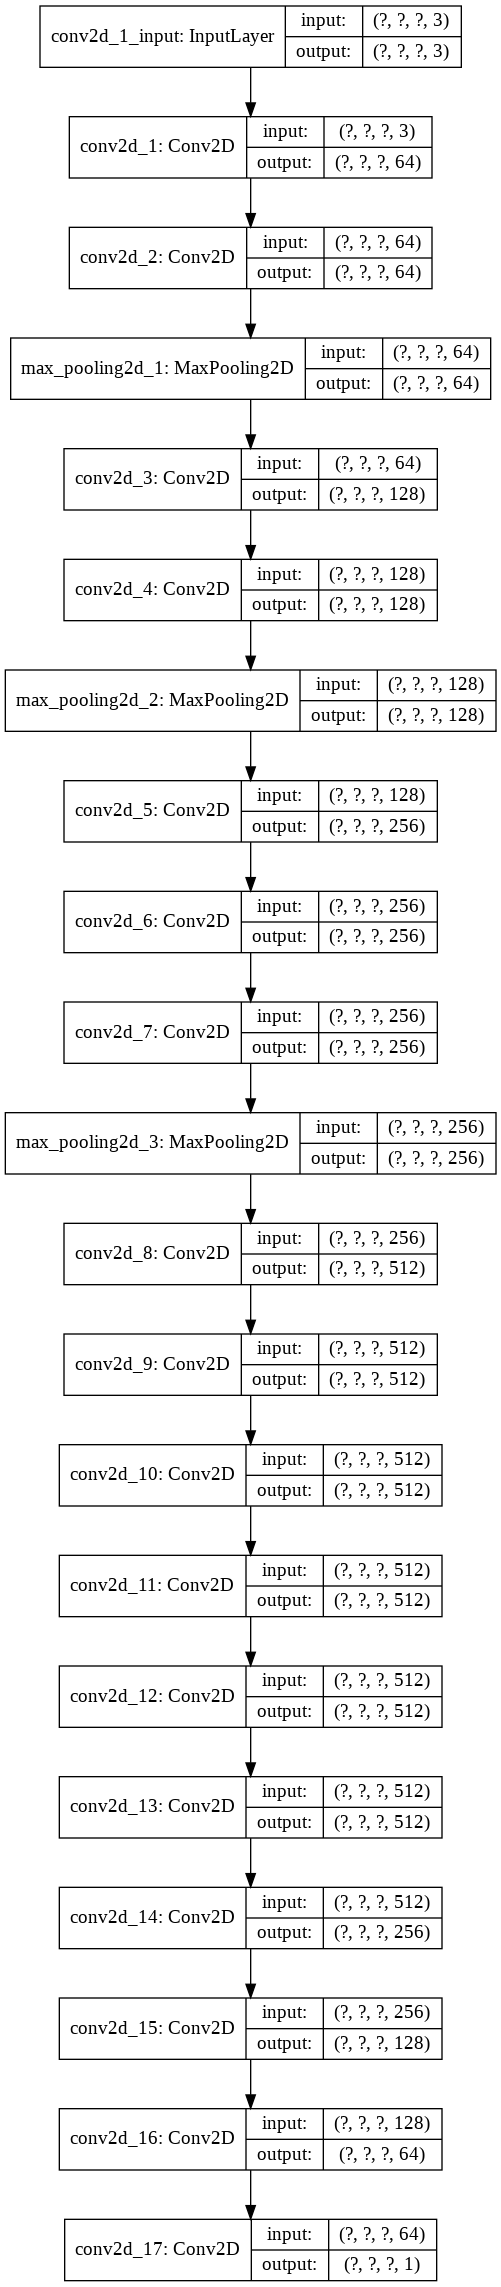

In [0]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
train_gen = image_generator(img_paths,5)
test_gen = image_generator(test_paths,10)

In [0]:
# sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
# model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])
# from keras.optimizers import Adam
# optimizer = Adam(lr=1e-5)
# # model = CSRNet(input_shape=(None, None, 3))
# model.compile(optimizer=optimizer, loss='MSE')

In [0]:
model_history = model.fit_generator(train_gen,epochs=250,steps_per_epoch= 60, validation_steps=10, validation_data=test_gen,verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


60/60 [==============================] - 138s 2s/step - loss: 0.0874 - mean_squared_error: 0.0740 - acc: 0.1818 - val_loss: 0.0855 - val_mean_squared_error: 0.0485 - val_acc: 0.1069
Epoch 2/250
60/60 [==============================] - 92s 2s/step - loss: 0.0726 - mean_squared_error: 0.0591 - acc: 0.2105 - val_loss: 0.0560 - val_mean_squared_error: 0.0211 - val_acc: 0.1711
Epoch 3/250
60/60 [==============================] - 83s 1s/step - loss: 0.0664 - mean_squared_error: 0.0394 - acc: 0.1678 - val_loss: 0.1056 - val_mean_squared_error: 0.0470 - val_acc: 0.0362
Epoch 4/250
60/60 [==============================] - 50s 833ms/step - loss: 0.0513 - mean_squared_error: 0.0343 - acc: 0.2117 - val_loss: 0.0418 - val_mean_squared_error: 0.0103 - val_acc: 0.1620
Epoch 5/250
60/60 [==============================] - 59s 991ms/step - loss: 0.0596 - mean_squared_error: 0.0420 - acc: 0.1798 - val_loss: 0.0572 - val_mean_squared_error: 0.0198 - val_acc: 0.2523
Epoch 6/250
60/60 [=====================

In [0]:
save_mod(model,"model_A_weights.h5","Model.json")

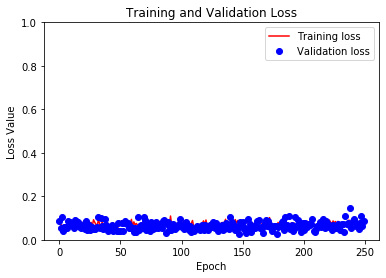

In [0]:
import matplotlib.pyplot as plt

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(250)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [0]:
import cv2
import h5py
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as c
from keras.models import model_from_json

In [0]:
def load_model():
    # Function to load and return neural network model 
    json_file = open('Model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("model_A_weights.h5")
    return loaded_model

def create_img(path):
    #Function to load,normalize and return image 
    print(path)
    im = Image.open(path).convert('RGB')
    
    im = np.array(im)
    
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225


    im = np.expand_dims(im,axis  = 0)
    return im

In [0]:
def predict(path):
    #Function to load image,predict heat map, generate count and return (count , image , heat map)
    model_load = load_model()
    image = create_img(path)
    ans = model_load.predict(image)
    count = np.sum(ans)
    return count,image,ans

In [0]:
ans,img,hmap = predict('part_A_final/train_data/images/IMG_1.jpg')

part_A_final/train_data/images/IMG_1.jpg


In [0]:
np.unique(hmap)

array([0.], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0


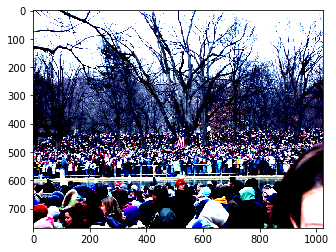

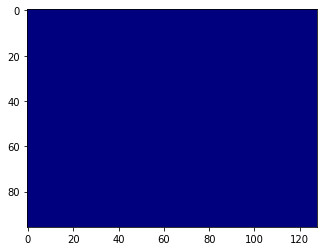

In [0]:
print(ans)
#Print count, image, heat map
plt.imshow(img.reshape(img.shape[1],img.shape[2],img.shape[3]))
plt.show()
plt.imshow(hmap.reshape(hmap.shape[1],hmap.shape[2]) , cmap = c.jet )
plt.show()

In [0]:
temp = h5py.File('/content/drive/My Drive/ShanghaiTech_h5/part_A_final/train_data/ground/IMG_1.h5' , 'r')
temp_1 = np.asarray(temp['density'])
# plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
# img = cv2.resize(temp_1,(int(temp_1.shape[1]/8),int(temp_1.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
# img = np.expand_dims(img,axis  = 3)
# print(np.sum(img)+1)

Original Count :  1544
